# Homework 3

## Course Name: Deep Learning
#### Lecturer: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Rahimi, Zahra Khoramnejad, Mehran Sarmadi


---
---
## 1 Introduction

In this notebook you have to design and train models for a time series prediction task on the provided dataset using these three different architectures:

- Simple RNN

- GRU

- LSTM

You will compare and rank them at the end of the notebook and explain why they were ranked that way.

---
### 1.1 Imports

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import copy

---
---
## 2 Dataset
Electric Production IP Dataset

In [4]:
df = pd.read_csv('./data/Electric_Production.csv', index_col='Date', parse_dates=True, dtype=np.float32)

In [5]:
df.head()

,Value
Date,
1985-01-01,72.505203
1985-02-01,70.671997
1985-03-01,62.450199
1985-04-01,57.471401
1985-05-01,55.315102


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float32
dtypes: float32(1)
memory usage: 4.7 KB


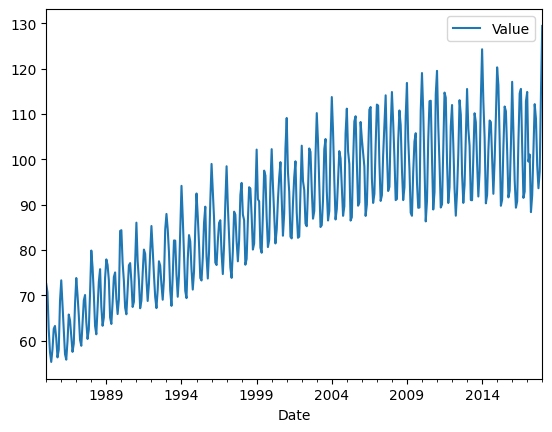

In [7]:
df.plot();

---
### 2.1 Load and prepare Dataset

In [8]:
def prepare_dataset(dataset, look_back):
    """Transform a time series data into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        look_back: Size of window for prediction
    """
    X, y = [], []
    dataset = np.array(dataset)
    data_length = len(dataset)
    for i in range(look_back, data_length):
        input = dataset[i-look_back: i]
        output = dataset[i]
        X.append(input)
        y.append(output)

    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
look_back = 60

data_length = len(df)

train_data_size = int(data_length * 0.75)
validaion_data_size = int(data_length * 0.25)


train_data = df[: train_data_size]
validation_data = df[train_data_size: ]


X_train, y_train = prepare_dataset(train_data, look_back)
X_val, y_val = prepare_dataset(validation_data, look_back)


X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)


print(  f"Shape of X_train data -> {X_train.shape} \n"
        f"Shape of y_train data -> {y_train.shape} \n"
        f"Shape of X_val data -> {X_val.shape} \n"
        f"Shape of y_val data -> {y_val.shape} \n"
    )


Shape of X_train data -> torch.Size([237, 60, 1]) 
Shape of y_train data -> torch.Size([237, 1]) 
Shape of X_val data -> torch.Size([40, 60, 1]) 
Shape of y_val data -> torch.Size([40, 1]) 



---
---
## 3 Trainer function

In [12]:
def trainer(model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs):
    early_stopping_patience = 150
    early_stopping_counter = 0

    valid_loss_min=np.inf
    best_model = copy.deepcopy(model)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()

        X_train, y_train = X_train.to(device), y_train.to(device)
        X_val, y_val = X_val.to(device), y_val.to(device)

        # Forward and loss
        out = model(X_train)
        loss = criterion(out, y_train)

        # Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        with torch.no_grad():
            model.eval()
            output_val = model(X_val)
            valid_loss = criterion(output_val, y_val)
            val_losses.append(valid_loss.item())

            if valid_loss <= valid_loss_min:
                best_model = best_model = copy.deepcopy(model)
                print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).')
                valid_loss_min = valid_loss
                early_stopping_counter = 0    # Reset counter if validation loss decreases
            else:
                print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
                early_stopping_counter += 1

            if early_stopping_counter > early_stopping_patience:
                print('Early stopped at epoch :', epoch)
                break

            print(f'\t Train_Loss: {loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

    return best_model, train_losses, val_losses

---
---
## 4 RNN

---
### 4.1 Define single RNN cell

In [23]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity

        # Define Needed Layers
        self.input_w = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.hidden_w = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        if bias:
            self.bias_ih = nn.Parameter(torch.Tensor(hidden_size)) # input2hidden
            self.bias_hh = nn.Parameter(torch.Tensor(hidden_size)) # hidden2hidden
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def forward(self, input, hx=None):
        if hx is None:
            hx = torch.zeros(input.size(0), self.hidden_size, dtype=input.dtype, device=input.device)
        gates = input @ self.input_w.t() + hx @ self.hidden_w.t()

        if self.bias:
            gates = gates + self.bias_ih + self.bias_hh

        if self.nonlinearity == "tanh":
            hy = torch.tanh(gates)
        elif self.nonlinearity == "relu":
            hy = torch.relu(gates)
        else:
            raise ValueError("Invalid activation function")
        return hy

---
### 4.2 RNN model

In [24]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn = []
        for _ in range(num_layers):
            self.rnn.append(RNNCell(input_size, hidden_size, bias))
        self.rnn = nn.ModuleList(self.rnn)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        batch_size, sequence, _ = input.size()
        if hx is None:
            hx = [torch.zeros(batch_size, self.hidden_size, dtype=input.dtype, device=input.device) for _ in range(self.num_layers)]
        out = []
        for s in range(sequence):
            i = input[:,s]
            for layer in range(self.num_layers):
                hx[layer] = self.rnn[layer](i, hx[layer])
                i = hx[layer]
            out.append(hx[-1])
        out = torch.stack(out)
        out = self.fc(out[-1])
        return out

---
### 4.3 Train RNN model and plot losses

In [25]:
# Instantiate model
SimpleRNN_model = SimpleRNN(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
SimpleRNN_model.to(device)

SimpleRNN(
  (rnn): ModuleList(
    (0): RNNCell()
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [26]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SimpleRNN_model.parameters(), lr = learning_rate)

In [27]:
SimpleRNN_best_model, train_losses, val_losses = trainer(SimpleRNN_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Epoch 0: Validation loss decreased (inf --> 10467.428711).
	 Train_Loss: 7893.8696 Val_Loss: 10467.4287  BEST VAL Loss: 10467.4287

Epoch 1: Validation loss decreased (10467.428711 --> 10349.484375).
	 Train_Loss: 7788.5195 Val_Loss: 10349.4844  BEST VAL Loss: 10349.4844

Epoch 2: Validation loss decreased (10349.484375 --> 10254.936523).
	 Train_Loss: 7690.7451 Val_Loss: 10254.9365  BEST VAL Loss: 10254.9365

Epoch 3: Validation loss decreased (10254.936523 --> 10170.878906).
	 Train_Loss: 7610.3784 Val_Loss: 10170.8789  BEST VAL Loss: 10170.8789

Epoch 4: Validation loss decreased (10170.878906 --> 10091.643555).
	 Train_Loss: 7538.4692 Val_Loss: 10091.6436  BEST VAL Loss: 10091.6436

Epoch 5: Validation loss decreased (10091.643555 --> 10012.592773).
	 Train_Loss: 7470.1978 Val_Loss: 10012.5928  BEST VAL Loss: 10012.5928

Epoch 6: Validation loss decreased (10012.592773 --> 9932.448242).
	 Train_Loss: 7401.7241 Val_Loss: 9932.4482  BEST VAL Loss: 9932.4482

Epoch 7: Validation loss 

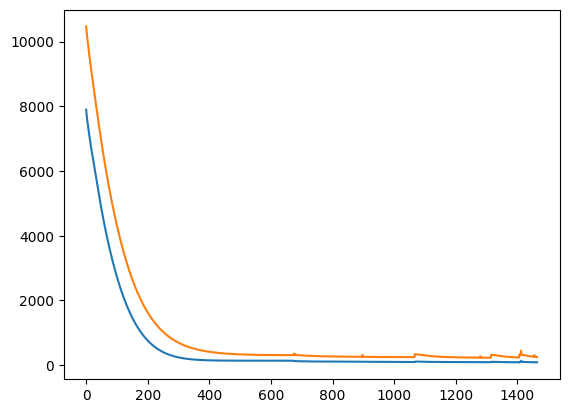

In [28]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 4.4 Evaluate model on validation data

In [29]:
val_predict_RNN = SimpleRNN_best_model(X_val)

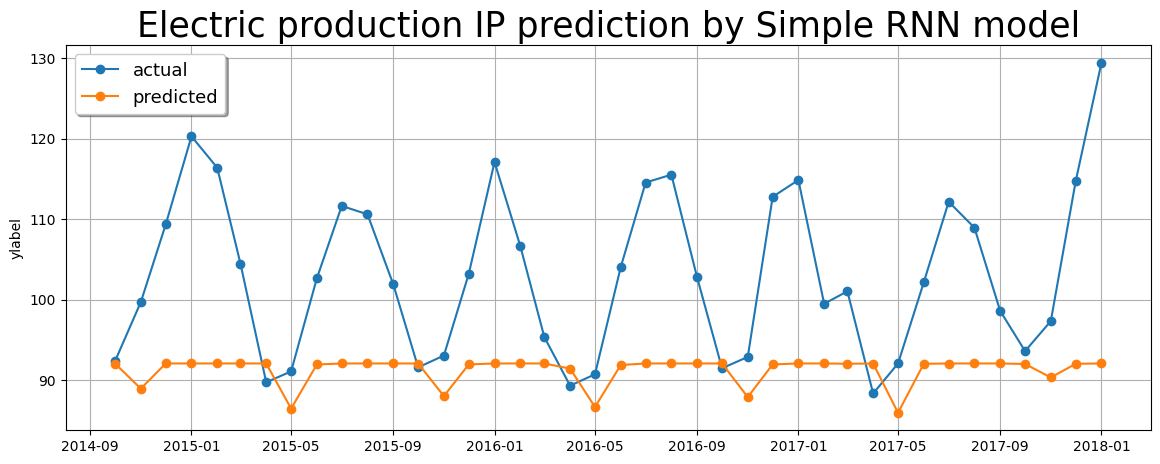

In [30]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by Simple RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 5 GRU

---
### 5.1 Define single GRU cell

In [31]:
class GRUCell(torch.nn.Module):
    
    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(GRUCell, self).__init__()
        self.input_length = input_length
        self.hidden_size = hidden_size
        self.bias = bias

        self.w_z = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.u_z = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.w_r = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.u_r = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.w_c = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.u_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        if self.bias:
            self.b_r = nn.Parameter(torch.Tensor(hidden_size))
            self.b_z = nn.Parameter(torch.Tensor(hidden_size))
            self.b_c = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.b_r = 0
            self.b_z = 0
            self.b_c = 0

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def reset_gate(self, x, h):
        r = torch.sigmoid(x @ self.w_r.T + h @ self.u_r.T + self.b_r)
        return r

    def update_gate(self, x, h):
        z = torch.sigmoid(x @ self.w_z.T + h @ self.u_z.T + self.b_z)
        return z

    def output_gate(self, x, h, r):
        n_t = torch.tanh(x @ self.w_c.T + (r * h) @ self.u_c.T + self.b_c)
        return n_t

    def forward(self, x, h):
        z = self.update_gate(x, h)
        r = self.reset_gate(x, h)
        n_t = self.output_gate(x, h, r)

        h_new = (1 - z) * n_t + z * h

        return h_new

---
### 5.2 GRU model

In [41]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        cell_list = []
        for i in range(num_layers):
            if i == 0:
                cell_list.append(GRUCell(input_size, hidden_size, bias))
            else:
                cell_list.append(GRUCell(hidden_size, hidden_size, bias))
        self.rnn_cell_list = nn.ModuleList(cell_list)
        self.fc = nn.Linear(hidden_size, output_size, bias)
    
    def forward(self, input, hx=None):
        batch_size, sequence, _ = input.size()
        if hx is None:
            hx = [torch.zeros(batch_size, self.hidden_size, dtype=input.dtype, device=input.device) for _ in range(self.num_layers)]
        out = []
        for s in range(sequence):
            i = input[:,s]
            for layer in range(self.num_layers):
                hx[layer] = self.rnn_cell_list[layer](i, hx[layer])
                i = hx[layer]
            out.append(hx[-1])
        out = torch.stack(out)
        out = self.fc(out[-1])
        return out

---
### 5.3 Train GRU model and plot losses

In [42]:
GRU_model = GRU(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
GRU_model.to(device)

GRU(
  (rnn_cell_list): ModuleList(
    (0): GRUCell()
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [43]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr = learning_rate)

In [44]:
GRU_best_model, train_losses, val_losses = trainer(GRU_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Epoch 0: Validation loss decreased (inf --> 10652.772461).
	 Train_Loss: 8034.0952 Val_Loss: 10652.7725  BEST VAL Loss: 10652.7725

Epoch 1: Validation loss decreased (10652.772461 --> 10572.939453).
	 Train_Loss: 7953.6113 Val_Loss: 10572.9395  BEST VAL Loss: 10572.9395

Epoch 2: Validation loss decreased (10572.939453 --> 10502.244141).
	 Train_Loss: 7881.8613 Val_Loss: 10502.2441  BEST VAL Loss: 10502.2441

Epoch 3: Validation loss decreased (10502.244141 --> 10433.889648).
	 Train_Loss: 7813.9697 Val_Loss: 10433.8896  BEST VAL Loss: 10433.8896

Epoch 4: Validation loss decreased (10433.889648 --> 10356.876953).
	 Train_Loss: 7744.8477 Val_Loss: 10356.8770  BEST VAL Loss: 10356.8770

Epoch 5: Validation loss decreased (10356.876953 --> 10264.852539).
	 Train_Loss: 7668.1523 Val_Loss: 10264.8525  BEST VAL Loss: 10264.8525

Epoch 6: Validation loss decreased (10264.852539 --> 10161.007812).
	 Train_Loss: 7581.7202 Val_Loss: 10161.0078  BEST VAL Loss: 10161.0078

Epoch 7: Validation lo

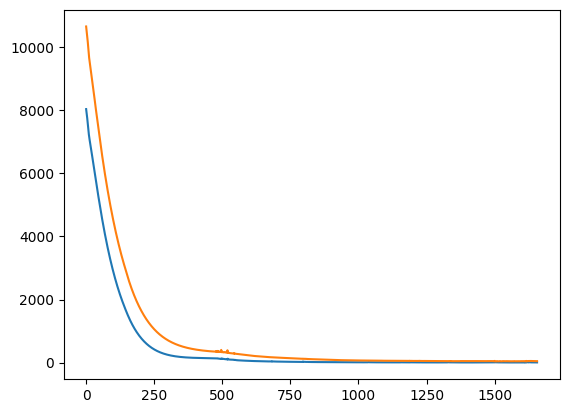

In [45]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 5.4 Evaluate model on validation data

In [46]:
val_predict_GRU = GRU_best_model(X_val)

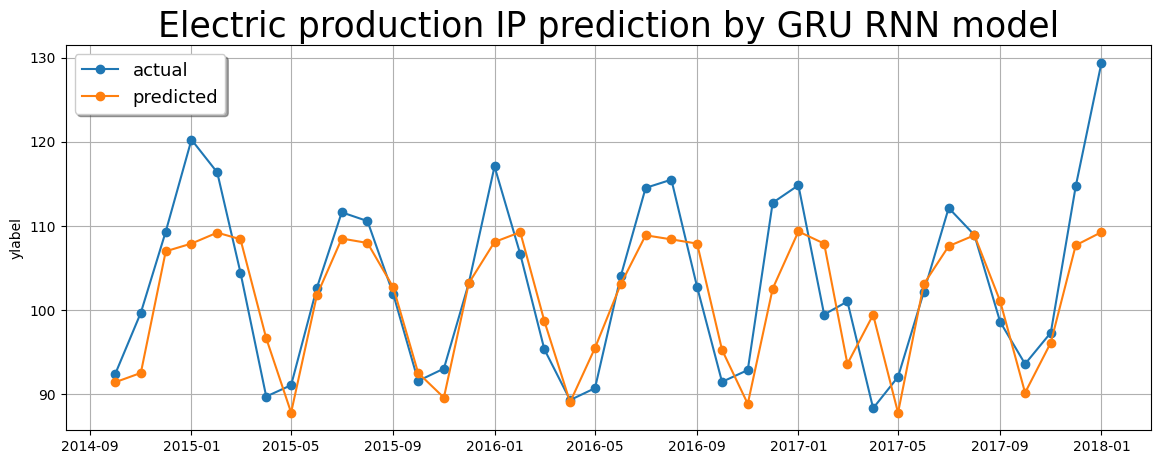

In [47]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by GRU RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 6 LSTM

---
### 6.1 Define single RNN cell

In [48]:
class LSTMCell(torch.nn.Module):
    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(LSTMCell, self).__init__()
        self.input_length = input_length
        self.hidden_size = hidden_size
        self.bias = bias

        self.w_f = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.u_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.w_i = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.u_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.w_o = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.u_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.w_c = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.u_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        if self.bias:
            self.b_f = nn.Parameter(torch.Tensor(hidden_size))
            self.b_i = nn.Parameter(torch.Tensor(hidden_size))
            self.b_o = nn.Parameter(torch.Tensor(hidden_size))
            self.b_c = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.b_f = 0
            self.b_i = 0
            self.b_o = 0
            self.b_c = 0

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def forget(self, x, h):
        fg = torch.sigmoid(x @ self.w_f.T + h @ self.u_f.T + self.b_f)
        return fg


    def input_gate(self, x, h):
        ig = torch.sigmoid(x @ self.w_i.T + h @ self.u_i.T + self.b_i)
        return ig


    def cell_memory_gate(self, i, f, x, h, c_prev):
        gates = torch.tanh(x @ self.w_c.T + h @ self.u_c.T + self.b_c)
        c_next = i * gates + f * c_prev
        return c_next


    def output_gate(self, x, h):
        og = torch.sigmoid(x @ self.w_o.T + h @ self.u_o.T + self.b_o)
        return og


    def forward(self, x, hx=None):
        if hx is None:
            hx = (torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype, device=x.device),
                  torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype, device=x.device))

        h_prev, c_prev = hx

        fg = self.forget(x, h_prev)
        ig = self.input_gate(x, h_prev)
        og = self.output_gate(x, h_prev)

        c_next = self.cell_memory_gate(ig, fg, x, h_prev, c_prev)

        h_next = og * torch.tanh(c_next)
        return h_next, c_next

---
### 6.2 LSTM model

In [68]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size

        cells = []
        for i in range(num_layers):
            if i == 0:
                cells.append(LSTMCell(input_size, hidden_size, bias))
            else:
                cells.append(LSTMCell(hidden_size, hidden_size, bias))
        self.rnn_cell_list = nn.ModuleList(cells)
        self.fc = nn.Linear(hidden_size, output_size, bias)

    def forward(self, input, hx=None):
        batch_size, sequence, _ = input.size()
        if hx is None:
            hx = [(torch.zeros(batch_size, self.hidden_size, dtype=input.dtype, device=input.device),
                   torch.zeros(batch_size, self.hidden_size, dtype=input.dtype, device=input.device))
                  for _ in range(self.num_layers)]

        h_t, c_t = list(zip(*hx))
        h_t = list(h_t)
        c_t = list(c_t)

        out = []
        for s in range(sequence):
            next_input = input[:,s]  
            for layer in range(self.num_layers):
                h_t[layer], c_t[layer] = self.rnn_cell_list[layer](next_input, (h_t[layer], c_t[layer]))
                next_input = h_t[layer]
            out.append(h_t[-1])

        out = torch.stack(out)
        out = self.fc(out[-1])
        return out

---
### 6.3 Train LSTM model and plot losses

In [69]:
LSTM_model = LSTM(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
LSTM_model.to(device)

LSTM(
  (rnn_cell_list): ModuleList(
    (0): LSTMCell()
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [70]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr = learning_rate)

In [71]:
LSTM_best_model, train_losses, val_losses = trainer(LSTM_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Epoch 0: Validation loss decreased (inf --> 10639.678711).
	 Train_Loss: 8027.1577 Val_Loss: 10639.6787  BEST VAL Loss: 10639.6787

Epoch 1: Validation loss decreased (10639.678711 --> 10552.540039).
	 Train_Loss: 7938.7686 Val_Loss: 10552.5400  BEST VAL Loss: 10552.5400

Epoch 2: Validation loss decreased (10552.540039 --> 10495.843750).
	 Train_Loss: 7864.7549 Val_Loss: 10495.8438  BEST VAL Loss: 10495.8438

Epoch 3: Validation loss decreased (10495.843750 --> 10434.509766).
	 Train_Loss: 7811.8325 Val_Loss: 10434.5098  BEST VAL Loss: 10434.5098

Epoch 4: Validation loss decreased (10434.509766 --> 10360.820312).
	 Train_Loss: 7757.7983 Val_Loss: 10360.8203  BEST VAL Loss: 10360.8203

Epoch 5: Validation loss decreased (10360.820312 --> 10300.435547).
	 Train_Loss: 7693.7212 Val_Loss: 10300.4355  BEST VAL Loss: 10300.4355

Epoch 6: Validation loss decreased (10300.435547 --> 10232.059570).
	 Train_Loss: 7638.3613 Val_Loss: 10232.0596  BEST VAL Loss: 10232.0596

Epoch 7: Validation lo

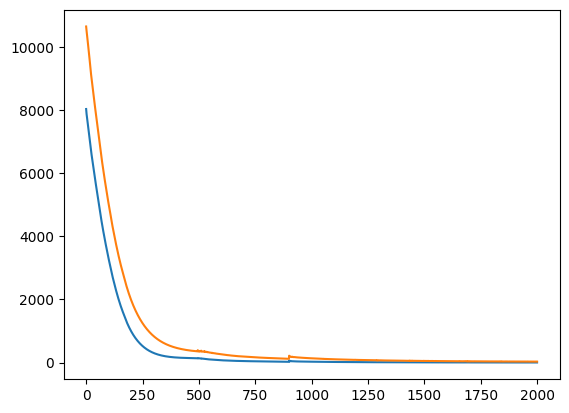

In [72]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 6.4 Evaluate model on validation data

In [73]:
val_predict_LSTM = LSTM_best_model(X_val)

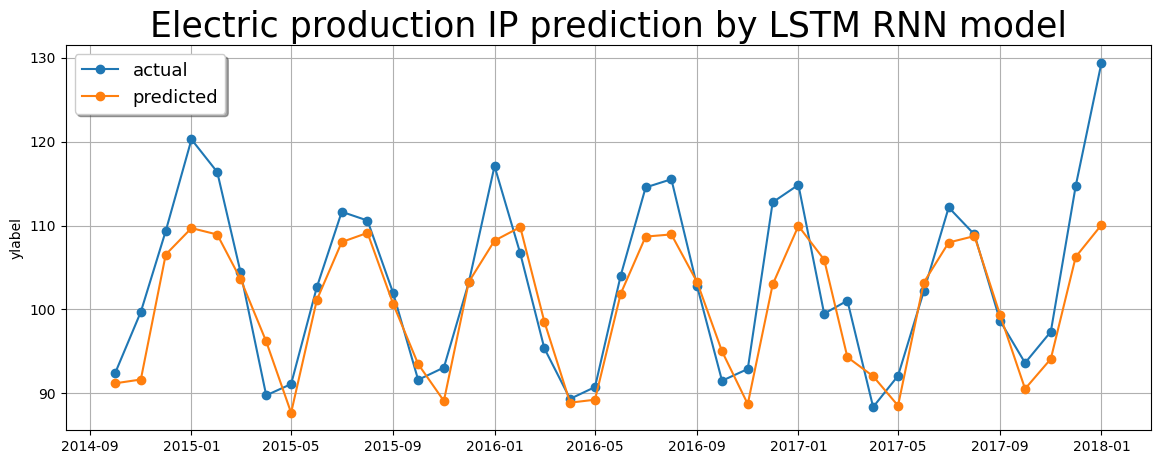

In [74]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by LSTM RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 7 Comaprison

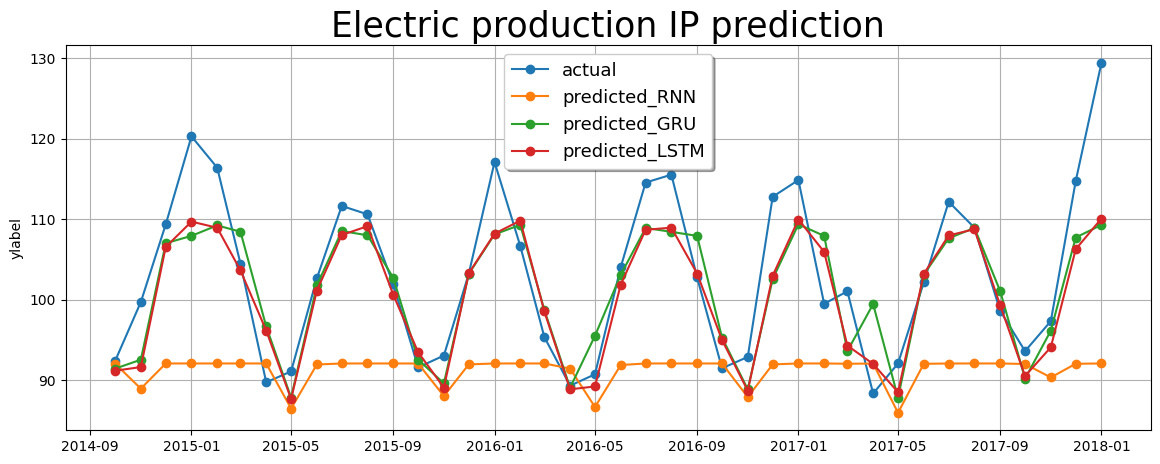

In [75]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted_RNN", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted_GRU", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted_LSTM", marker="o")
plt.title("Electric production IP prediction", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()


<b>1-Rank these architectures based on their performance?

2-Why are they ranked in this order?

3-Run the notebook again with look_back = 15.
write about the difference in the comparison plot and the possible cause for that difference.</b>

<font color='#73FF73'><b>Your answer:</b></font>

As we can see, RNN was the worst in performance and after that we have GRU and after that ther is LSTM.</br>
Because RNN's have simple structure, they suffer from vanishing gradient problem. LSTMs are designed to address the vanishing gradient problem by using a special type of memory cell that can store information over long periods of time. LSTMs have gates that control how information flows into, out of, and within the memory cell. These gates allow LSTMs to selectively remember and forget information, which is important for processing long sequences. GRUs are a simplified version of LSTMs that are easier to train and run. GRUs do not have as many gates as LSTMs, and they do not have a separate memory cell. However, they are still able to effectively process long sequences.</br>
If we change the look_back and make it less, the model will be more likely to overfit and miss the long-term relations. And we can see that tthe model performance will be poorer.

#### I did this homework with Ali Falahati